In [17]:
import numpy as np
import pickle
from matplotlib.animation import FFMpegWriter
import cv2 
import src.utils as utils
from tqdm import tqdm
import src.utils as utils
import matplotlib.pyplot as plt
import glob
import torch

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def undistort(im,idx):
    shape = im.shape
    im_flat = im.flatten('F')
    im_flat = im_flat[idx]
    return np.reshape(im_flat,(shape[0], shape[1]),'F')

# Load data

In [38]:
idx = 0
data_dir = '/data/LiftFly3D/mouse/'

#mousetracker
files = sorted(glob.glob(data_dir + '*.pkl'))
videos = sorted(glob.glob(data_dir + '*.avi'))
poses = pickle.load(open(files[idx],'rb'))
index = poses['index']

#LiftPose3D prediction
data = torch.load(data_dir + '/test_results.pth.tar')
tar_mean = torch.load(data_dir + '/stat_3d.pth.tar')['mean']
tar_std = torch.load(data_dir + '/stat_3d.pth.tar')['std']
targets_1d = torch.load(data_dir + '/stat_3d.pth.tar')['targets_1d']
tar_offset = np.vstack(torch.load(data_dir + '/stat_3d.pth.tar')['offset'].values())

inp_mean = torch.load(data_dir + '/stat_2d.pth.tar')['mean']
inp_std = torch.load(data_dir + '/stat_2d.pth.tar')['std']
targets_2d = torch.load(data_dir + '/stat_2d.pth.tar')['targets_2d']
inp_offset = np.vstack(torch.load(data_dir + '/stat_2d.pth.tar')['offset'].values())

tar = utils.unNormalizeData(data['target'], tar_mean[targets_1d], tar_std[targets_1d])
tar = utils.expand(tar,targets_1d,len(tar_mean))
tar += tar_offset
out = utils.unNormalizeData(data['output'], tar_mean[targets_1d], tar_std[targets_1d])
out = utils.expand(out,targets_1d,len(tar_mean))
out += tar_offset
inp = utils.unNormalizeData(data['input'], inp_mean[targets_2d], inp_std[targets_2d])
inp = utils.expand(inp,targets_2d,len(inp_mean))
inp += inp_offset

#images
imgs = utils.video_to_imgs(videos[idx])
imgs = [rgb2gray(im) for im in imgs]
imgs = [undistort(im,poses['distort'].flatten()) for im in imgs]

/home/gosztolai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app
/home/gosztolai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



100%|██████████| 462/462 [00:10<00:00, 45.81it/s]


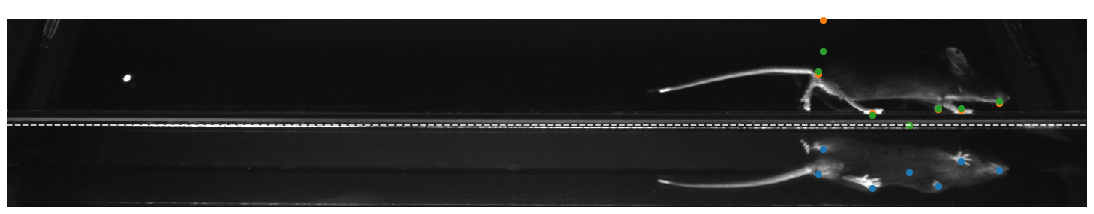

In [42]:
fig = plt.figure(figsize=(15,6))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

bottom = poses['points2d'][0,:,:,:]
bottom = np.reshape(bottom, (bottom.shape[0], bottom.shape[1]*bottom.shape[2]))
side = poses['points2d'][1,:,:,:]
side = np.reshape(side, (side.shape[0], side.shape[1]*side.shape[2]))
            
writer = FFMpegWriter(fps=10)
with writer.saving(fig, "DLC_prediction.mp4", 50):
    for i in tqdm(range(len(index))):  
        plt.cla()
        
        bottom_x, bottom_y = inp[i,::2], inp[i,1::2]
        side_x, side_y = inp[i,::2], tar[i,:]
        side_x_pred, side_y_pred = inp[i,::2], out[i,:]

        plt.imshow(imgs[index[i]],cmap='gray', vmin=0, vmax=255)
        plt.axhline(140, color="white", linestyle="--")
        
        plt.scatter(bottom_x,bottom_y)
        plt.scatter(side_x,side_y)
        plt.scatter(side_x_pred,side_y_pred)
                         
        #plt.text(120, 80, str(i), fontsize=50, color='white')
        
        plt.axis('off')
        writer.grab_frame()    